In [1]:
%%capture
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')
# import tikzmagic
%load_ext tikzmagic
# matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

# Language Models

## Language Models

calculate the **probability of seeing a sequence of words**. 

For example: how likely is the following sequence?

> We're going to win bigly. 

Is it more likely than this one?

> We're going to win big league.

## Use Cases: Machine Translation

> Wir werden haushoch gewinnen

translates to?

> We will win by a mile

or 

> We will win bigly

## Use Cases: Speech Recognition

What did he [say](https://www.theguardian.com/us-news/video/2016/may/04/donald-trump-we-are-going-to-win-bigly-believe-me-video)?

> We're going to win bigly

or

> We're going to win big league

## Use Cases: Natural Language Generation

https://twitter.com/deepdrumpf

Other applications?

## Formally
Models the probability 

$$\prob(w_1,\ldots,w_d)$$ 

of observing sequences of words \\(w_1,\ldots,w_d\\). 

Without loss of generality: 

\begin{align}
\prob(w_1,\ldots,w_d) &= p(w_1) p(w_2|w_1) p(w_3|w_1, w_2) \ldots \\
 &= \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1})
\end{align}

### Structured Prediction

predict word $y=w_i$ 
* conditioned on history $\x=w_1,\ldots,w_{i-1}$.

## N-Gram Language Models

Impossible to estimate different probability for each history 

$$
\x=w_1,\ldots,w_{i-1}
$$

### Change **representation**
truncate history to last $n-1$ words: 

$$
\mathbf{f}(\x)=w_{i-(n-1)},\ldots,w_{i-1}
$$

$\prob(\text{bigly}|\text{...,blah, blah, blah, we, will, win}) \\ 
= \prob(\text{bigly}|\text{we, will, win})$

### Unigram LM

Set $n=1$:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

$\prob(\text{bigly}|\text{we, will, win}) = \prob(\text{bigly})$

## Uniform LM
Same probability for each word in a *vocabulary* \\(\vocab\\):

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

$\prob(\text{big}) = \prob(\text{bigly}) = \frac{1}{|\vocab|}$

Let us look at a training set and create a uniform LM from it.

In [2]:
train[:10]

['[BAR]', 'Can', "'t", 'even', 'call', 'this', 'a', 'blues', 'song', '[/BAR]']

In [3]:
vocab = set(train)
baseline = UniformLM(vocab)
sum([baseline.probability(w) for w in vocab])

0.9999999999999173

What about other words? Summing up probabilities?

## Sampling
* Sampling from an LM is easy and instructive
* Usually, the better the LM, the better the samples

Sample **incrementally**, one word at a time 

In [4]:
def sample(lm, init, amount):
    words = list(lm.vocab)
    result = []
    result += init
    for _ in range(0, amount):
        history = result[-(lm.order - 1):]
        probs = [lm.probability(word, *history) for word in words]
        sampled = np.random.choice(words,p=probs)
        result.append(sampled)
    return result

In [5]:
sample(baseline, [], 10)

['prepared',
 'mojo',
 'richer',
 'Speaking',
 'quit',
 '120',
 'sufferin',
 'dick',
 'dig',
 'tapes']

## Evaluation
* **Extrinsic**: how it improves a downstream task?
* **Intrinsic**: how good does it model language?

## Intrinsic Evaluation
**Shannon Game**: Predict next word, win if prediction match words in actual corpus (or you gave it high probability)

> Our horrible trade agreements with [???]

Formalised by ...

### Perplexity 
Given test sequence \\(w_1,\ldots,w_T\\), perplexity \\(\perplexity\\) is **geometric mean of inverse probabilities**:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\frac{1}{\prob(w_1)} \frac{1}{\prob(w_2|w_1)} \ldots} \\
&= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-n},\ldots,w_{i-1})}}
\end{align}

### Interpretation

Consider LM where 
* each token has exactly **2** words with $\frac{1}{2}$ probability
* one of both is the true word in the test set

Then 

* $\perplexity(w_1,\ldots,w_T) = \sqrt[T]{2 \cdot 2  \cdot\ldots} = 2$
* Perplexity $\approx$ average number of choices

Perplexity of uniform LM on a test set?

In [6]:
perplexity(baseline, test)

inf

Problem: model assigns **zero probability** to words not in the vocabulary. 

In [7]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:3]

[('does', 0.0), ('Ceremonies', 0.0), ('Masquerading', 0.0)]

## The Long Tail
New words not specific to our corpus: 
* long **tail** of words that appear only a few times
* each has low probability, but probability of seeing any long tail word is high


Let us plot word frequency ranks (x-axis) against frequency (y-axis) 

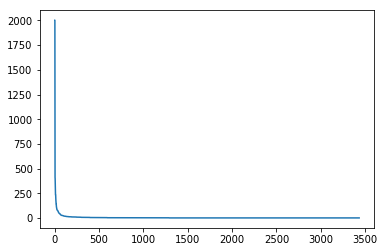

In [8]:
plt.xscale('linear')
plt.yscale('linear')
plt.plot(ranks, sorted_counts)

In log-space such rank vs frequency graphs are **linear** 

* Known as **Zipf's Law**

Let \\(r\_w\\) be the rank of a word \\(w\\), and \\(f\_w\\) its frequency:

$$
  f_w \propto \frac{1}{r_w}.
$$

* Also true in [random text](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.164.8422&rep=rep1&type=pdf)

## Out-of-Vocabularly (OOV) Tokens
There will always be words with zero counts in your training set.

Solutions:
* Remove unseen words from test set (bad)
* Move probability mass to unseen words (good, discuss later)
* Replace unseen words with out-of-vocabularly token, estimate its probability

### Inserting OOV Tokens

In [9]:
replace_OOVs(baseline.vocab, test[:10])

['[BAR]',
 'scratched',
 '[/BAR]',
 '[BAR]',
 'What',
 '[OOV]',
 'it',
 'take',
 '[/BAR]',
 '[BAR]']

### Estimate `OOV` probability
What is the probability of seeing a word you haven't seen before?

Consider the "words"

> AA AA BB BB AA

Going left to right, how often do I see new words?

Inject `OOV` tokens to mark these "new word events"

In [10]:
inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

Now train on replaced data...

In [11]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test)

1290.0000000049852

What does this perplexity correspond to?

## Training N-Gram Language Models

What are the parameters of a n-gram LM?

One parameter $\param_{w,h}$ for each word $w$ and history $h$ pair:

$$
\prob_\params(w|h) = \param_{w,h}
$$

$\prob_\params(\text{bigly}|\text{win}) = \param_{\text{bigly, win}}$

### Maximum Likelihood Estimate

Assume training set \\(\train=(w_1,\ldots,w_d)\\)

### Maximum Likelihood Estimate

Find \\(\params\\) that maximizes the log-likelihood of \\(\train\\):

$$
\params^* = \argmax_\params \log p_\params(\train)
$$

where

$$
\prob_\params(\train) = \ldots \prob_\params(w_i|\ldots w_{i-1}) \prob_\params(w_{i+1}|\ldots w_{i}) \ldots 
$$

**Structured Prediction**: continuous optimization problem with reward 

Maximum-log-likelihood estimate (MLE) can be calculated in **[closed form](notebooks/chapters/mle.ipynb)**:
$$
\prob_{\params^*}(w|h) = \param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

Many LM variants: different estimation of counts. 

## Training a Unigram Model
Let us train a unigram model

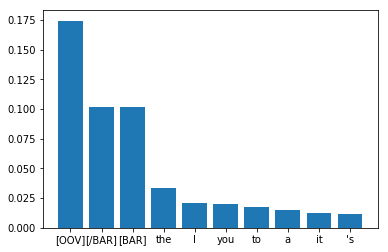

In [12]:
unigram = NGramLM(oov_train,1)
plot_probabilities(unigram)
# sum([unigram.probability(w) for w in unigram.vocab])

The unigram LM has substantially reduced (and hence better) perplexity:

In [13]:
perplexity(unigram,oov_test)

91.4414922652717

Its samples look (a little) more reasonable:

In [14]:
sample(unigram, [], 10)

['[/BAR]', 'my', 'it', 'It', '[/BAR]', '[OOV]', 'a', '[OOV]', 'All', 'your']

## Bigram Model
We can do better by setting $n=2$

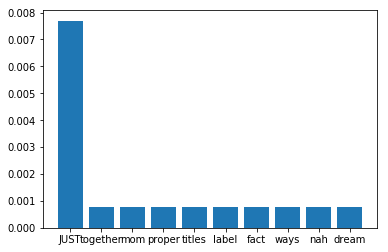

In [15]:
bigram = NGramLM(oov_train,2)
laplace2 = LaplaceLM(bigram,1.0)
plot_probabilities(laplace2, ("OUT",))
# sum([bigram.probability(w,"I") for w in bigram.vocab])

Samples should look (slightly) more fluent:

In [16]:
" ".join(sample(bigram, ['FIND'], 30))

"FIND OUT JUST HOW REAL IT IS [/BAR] [BAR] [OOV] my world gets [OOV] cause [OOV] straight [/BAR] [BAR] I [OOV] finish last from good [OOV] gettin ' like this [OOV]"

How about perplexity?

In [17]:
perplexity(bigram,oov_test)

inf

Some contexts where OOV word (and others) haven't been seen, hence 0 probability.

In [18]:
bigram.probability("[OOV]","money")

0.0

## Smoothing

Maximum likelihood 
* **underestimates** true probability of some words 
* **overestimates** the probabilities of other

Solution: _smooth_ the probabilities and **move mass** from seen to unseen events.

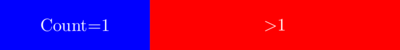

In [19]:
%%tikz
\fill[blue] (0,0) rectangle (3,1) node[pos=0.5,white] {Count=1};
\fill[red] (3,0) rectangle (8,1) node[pos=0.5,white] {$>$1};

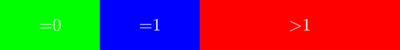

In [20]:
%%tikz
\fill[green] (0,0) rectangle (2,1) node[pos=0.5,white] {=0};
\fill[blue] (2,0) rectangle (4,1) node[pos=0.5,white] {=1};
\fill[red] (4,0) rectangle (8,1) node[pos=0.5,white] {$>$1};

### Laplace Smoothing

Add **pseudo counts** to each event in the dataset 

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

Bayesian view: *maximum posteriori* estimate under a dirichlet prior on parameters.

In [21]:
laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0007692307692307692

Perplexity should look better now:

In [22]:
perplexity(laplace_bigram,oov_test)

72.41090509288753

### Example
Consider three events:

|word |train count | MLE | Laplace | Same Denom. |
|-----------------------------|
| smally      | 0 | ?   | ? | ? |
| bigly       | 1 | ?   | ? | ? |
| tremendously| 2 | ?   | ? | ? |

### Good Smoothing
The closer smoothed counts are to test set counts, the better (prove!)

Easier to assess **on aggregate**:

How often is a word with training count $c$, on average, in test set? 
* $c=0$: usually more often than $c$
* $c>0$: usually less often than $c$

How close are smoothed counts to these test counts?

In [23]:
pd.DataFrame(frame, 
             columns = ["Train Count", "Test Count", "Laplace Count"])

,Train Count,Test Count,Laplace Count
0,0,0.003375,0.004950
1,1,0.437487,0.301893
2,2,1.115207,0.754602
3,3,1.661538,1.212537
4,4,2.675325,1.572842
5,5,4.101852,2.280637
6,6,4.688312,2.562516
7,7,5.392857,3.577428


Test counts usually between 0.6 and 1.4 smaller than train counts!
* In larger datasets even more consistent
* Useful for smoothing? See [exercise](../exercises/language_models.ipynb)!  

### Interpolation
* Laplace Smoothing assigns mass **uniformly** to the words that haven't been seen.

In [24]:
laplace_bigram.probability('skies','skies'), \
laplace_bigram.probability('[/BAR]','skies')

(0.0007633587786259542, 0.0007633587786259542)

Not all unseen words (in a context) are equal

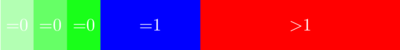

In [25]:
%%tikz
\fill[green!30!white] (0,0) rectangle (0.66,1) node[pos=0.5,white] {=0};
\fill[green!60!white] (0.66,0) rectangle (1.33,1) node[pos=0.5,white] {=0};
\fill[green!90!white] (1.33,0) rectangle (2,1) node[pos=0.5,white] {=0};
\fill[blue] (2,0) rectangle (4,1) node[pos=0.5,white] {=1};
\fill[red] (4,0) rectangle (8,1) node[pos=0.5,white] {$>$1};

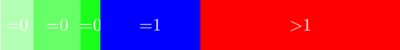

In [26]:
%%tikz
\fill[green!30!white] (0,0) rectangle (0.66,1) node[pos=0.5,white] {=0};
\fill[green!60!white] (0.66,0) rectangle (1.60,1) node[pos=0.5,white] {=0};
\fill[green!90!white] (1.60,0) rectangle (2,1) node[pos=0.5,white] {=0};
\fill[blue] (2,0) rectangle (4,1) node[pos=0.5,white] {=1};
\fill[red] (4,0) rectangle (8,1) node[pos=0.5,white] {$>$1};

With **interpolation** We can do better: 
* give more mass to words likely under the $n-1$-gram model. 
    * Use $\prob(\text{skies})$ for estimating $\prob(\text{skies}|\text{likes})$
* Combine $n$-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n},\ldots,w_{i-1}) + \\ (1 - \alpha) \cdot \prob''(w_i|w_{i-n+1},\ldots,w_{i-1})
$$


In [27]:
interpolated = InterpolatedLM(bigram,unigram,0.01)
interpolated.probability('skies','skies'), \
interpolated.probability('[/BAR]','skies')

(0.00010054844606946984, 0.10059872029250458)

Can we find a good $\alpha$ parameter? Tune on some dev set!

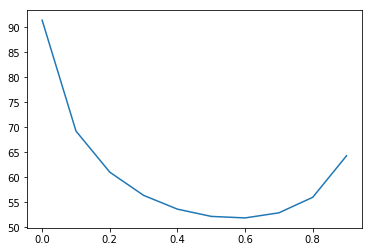

In [28]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(bigram,unigram,alpha),oov_test) 
                for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
* When we have counts for an event, trust these counts and not the simpler model
    * use $\prob(\text{bigly}|\text{win})$ if you have seen $(\text{win, bigly})$, not $\prob(\text{bigly})$
* **back-off** only when no counts for a given event are available.

### Stupid Backoff
Let \\(w\\) be a word and \\(h_{n}\\) an n-gram of length \\(n\\):  

$$
\prob_{\mbox{Stupid}}(w|h_n) = 
\begin{cases}
\frac{\counts{\train}{h_n,w}}{\counts{\train}{h_n}}  &= \mbox{if }\counts{\train}{h_n,w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{n-1}) & \mbox{otherwise}
\end{cases}
$$

What is the problem with this model?

In [29]:
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0647115579930844

"proper backoff models" do not have this problem, e.g. the Katz-Backoff method. See external material for a deeper discussion of these.

## Summary

* LMs model probability of sequences of words 
* Defined in terms of "next-word" distributions conditioned on history
* N-gram models truncate history representation
* Often trained by maximizing log-likelihood of training data and ...
* smoothing to deal with sparsity


## Background Reading

* Jurafsky & Martin, Speech and Language Processing: Chapter 4, N-Grams.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)